# LACSS Supervised Training Demo

This notebook shows the general workflow of supervised training an LACSS model from scratch.

This data uses a small dataset from the [Cell Image Library](http://www.cellimagelibrary.org/home) collection.

We will go through these steps:

- Setup the data pipeline
- Initialize a model trainer
- Perform model training
- Visualize the results

## Setting up the environment

In [1]:
!pip install "lacss[train] @ git+https://github.com/jiyuuchc/lacss"

  Cloning https://github.com/jiyuuchc/lacss to /tmp/pip-install-sbkt4ua0/lacss_b247e48fbd884066b0f6c6ced29188a9
  Running command git clone --filter=blob:none --quiet https://github.com/jiyuuchc/lacss /tmp/pip-install-sbkt4ua0/lacss_b247e48fbd884066b0f6c6ced29188a9
  Resolved https://github.com/jiyuuchc/lacss to commit d714d4c08ffc0925a79bfbba308f32b4775f84f1
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of orbax-checkpoint to determine which version is compatib

In [4]:
from pathlib import Path

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import pprint

from lacss.utils import show_images

## Data pipeline

--2025-04-07 13:07:24--  https://data.mendeley.com/public-files/datasets/894mmsd9nj/files/568e524f-9a95-45a6-9f80-3619969c2a37/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/305fe4d3-50bf-4e9b-89c7-fca353116d70 [following]
--2025-04-07 13:07:24--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/305fe4d3-50bf-4e9b-89c7-fca353116d70
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.68.114, 52.218.36.43, 52.92.36.194, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.68.114|:443... 

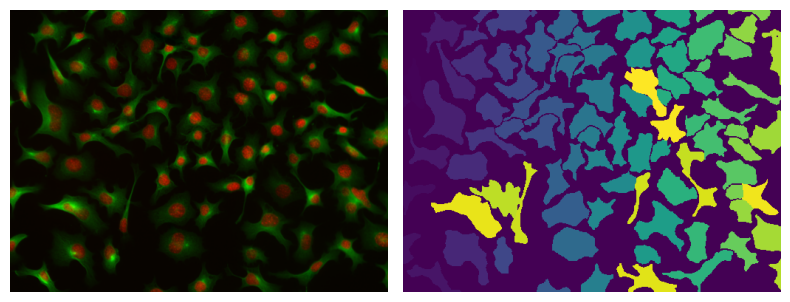

In [5]:
# First download the dataset

!wget -c https://data.mendeley.com/public-files/datasets/894mmsd9nj/files/568e524f-9a95-45a6-9f80-3619969c2a37/file_downloaded -O images.zip

import zipfile

data_path = Path('image_data')
with zipfile.ZipFile('images.zip', "r") as f:
    f.extractall(data_path)

img = imageio.imread(data_path / 'train' / '000_img.png')
gt = imageio.imread(data_path / 'train'/ '000_masks.png')

show_images([img, gt])

Lacss expect training data from a python generator that produces the following data:

```
x_data, y_data = (
  {
    "image": ndarray[B, W, H, C],
    "gt_locations": ndarray[B, N, 2]
  },
  {
    "gt_labels": ndarray[B, W, H]
  }
)
```

In [6]:
from lacss.data import img_mask_pair_generator
from lacss.data.utils import gf_batch, gf_cycle, image_standardization
import lacss.data.augment_ as augment

BATCHSIZE = 1

@gf_batch(batch_size=BATCHSIZE)
@gf_cycle
def dataset_generator():
    imgfiles = [data_path / 'train' / f'{k:03d}_img.png' for k in range(89)]
    maskfiles = [data_path / 'train'/ f'{k:03d}_masks.png' for k in range(89)]

    for data in img_mask_pair_generator(imgfiles, maskfiles):

        data['image_mask'] = data['label']

        data = augment.pad_to_size(data, target_size=[384, 512])

        # simple augmentation
        data = augment.flip_left_right(data, p = 0.5)
        data = augment.flip_up_down(data, p = 0.5)

        # It is important to pad the locations tensor so that all elements of the dataset are of the same shape
        locations = data['centroids']
        n_pad = 512 - len(locations)
        locations = np.pad(locations, [[0, n_pad], [0,0]], constant_values=-1)

        yield (
            dict(
                image = image_standardization(data['image']),
                gt_locations = locations,
            ),
            dict(
                gt_labels = data['image_mask'],
            ),
        )

## Initialize a trainer

The ```lacss.train.Trainer``` class is the main interface we use for training. It needs a few things to start:

- A model definition.
- A optimizer from optax library
- Definiation of losses to be trained on
- An optional strategy specify the training backend to use. Here we used VMapped which is suitable for single GPU training on batched data.

In [7]:
import optax
from lacss.modules import Lacss
from lacss.losses import supervised_instance_loss
from lacss.train import Trainer, VMapped, LossLog, train_fn

losses = [
    # detection losses are computed during the forward pass
    "losses/lpn_detection_loss",
    "losses/lpn_localization_loss",
    # segmentation loss is computed with an outside function
    # also we set a low loss-weight
    LossLog(supervised_instance_loss, 0.01),
]

trainer = Trainer(
    model = Lacss.get_small_model(),
    optimizer = optax.adam(1e-4),
    losses = losses,
    strategy=VMapped,
)

it = trainer.train(dataset_generator, method=train_fn)

In [30]:
import json
import os
import numpy as np
from PIL import Image
import imageio
from pycocotools import mask as coco_mask  # Для декодирования RLE

# Загрузка COCO-аннотации
with open("instances_Train.json", "r") as f:
    coco_data = json.load(f)

# Создаем папки для масок и изображений
os.makedirs("custom_data/train", exist_ok=True)

for img_info in coco_data["images"]:
    img_id = img_info["id"]
    img_name = img_info["file_name"]
    img_path = os.path.join("", img_name)  # Путь к исходным изображениям

    img = imageio.imread(img_path)
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint16)

    for ann in coco_data["annotations"]:
        if ann["image_id"] == img_id:
            if ann["iscrowd"] == 1:
                # Декодирование RLE-маски (для iscrowd=1)
                rle = coco_mask.frPyObjects(ann["segmentation"], h, w)
                m = coco_mask.decode(rle)  # Декодируем в бинарную маску
                mask[m > 0] = ann["category_id"]
            else:
                # Обработка полигонов (для iscrowd=0)
                for seg in ann["segmentation"]:
                    poly = np.array(seg).reshape(-1, 2)
                    from skimage.draw import polygon
                    rr, cc = polygon(poly[:, 1], poly[:, 0], shape=(h, w))
                    mask[rr, cc] = ann["category_id"]

    # Сохраняем изображение и маску
    idx = img_id  # или другой порядковый номер
    imageio.imwrite(f"custom_data/train/{idx:03d}_img.png", img)
    imageio.imwrite(f"custom_data/train/{idx:03d}_masks.png", mask)

<ipython-input-30-7e801eae6ef8>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [31]:
from pathlib import Path
import imageio
import numpy as np
from lacss.data import img_mask_pair_generator
from lacss.data.utils import gf_batch, gf_cycle, image_standardization
import lacss.data.augment_ as augment

BATCHSIZE = 1
data_path = Path("custom_data")

@gf_batch(batch_size=BATCHSIZE)
@gf_cycle
def custom_dataset_generator():
    imgfiles = sorted(data_path.glob("train/*_img.png"))
    maskfiles = sorted(data_path.glob("train/*_masks.png"))

    for data in img_mask_pair_generator(imgfiles, maskfiles):
        # Применяем random crop первым делом
        data = augment.random_crop(data, target_size=[384, 512])

        data['image_mask'] = data['label']

        # Аугментации (после кропа)
        data = augment.flip_left_right(data, p=0.5)
        data = augment.flip_up_down(data, p=0.5)

        # Обработка центроидов
        locations = data['centroids']
        n_pad = 512 - len(locations)
        locations = np.pad(locations, [[0, n_pad], [0, 0]], constant_values=-1)

        yield (
            dict(
                image=image_standardization(data['image']),
                gt_locations=locations,
            ),
            dict(
                gt_labels=data['image_mask'],
            ),
        )

In [ ]:
# Продолжаем обучение с текущими весами
trainer = Trainer(
    model=trainer.model,  # Используем уже обученную модель
    optimizer=optax.adam(1e-5),  # Уменьшаем learning rate для fine-tuning
    losses=losses,
    strategy=VMapped,
)

it = trainer.train(custom_dataset_generator, method=train_fn)

# Запускаем обучение
n_steps = 6000  # Меньше шагов, так как модель уже предобучена
for step in tqdm(range(n_steps)):
    if (step + 1) % 1000 == 0:
        print(it.loss)
        it.reset_loss_logs()
    next(it)

  0%|          | 0/6000 [00:00<?, ?it/s]

## Training

In [ ]:
from tqdm import tqdm

n_steps = 12000
validation_interval = 3000

for step in tqdm(range(n_steps)):

    if (step + 1) % validation_interval == 0:
        print(it.loss)
        it.reset_loss_logs()

    next(it)


## Visualize the model prediction

In [28]:
from lacss.deploy.predict import Predictor
from lacss.data.utils import image_standardization
from skimage.color import label2rgb

predictor = Predictor((trainer.model, it.parameters))

image = imageio.imread(data_path/'test'/'000_img.png')
gt_label = imageio.imread(data_path/'test'/'000_masks.png')

# prediction
label = predictor.predict(image)["pred_label"]

show_images([
    image,
    label2rgb(np.asarray(label), bg_label=0),
    label2rgb(gt_label, bg_label=0),
])
titles = ['Input', "Prediction", "Ground Truth"]
[ax.set_title(title) for ax, title in zip(plt.gcf().get_axes(), titles)]

<ipython-input-28-1ba83af700a0>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(data_path/'test'/'000_img.png')


FileNotFoundError: No such file: '/content/custom_data/test/000_img.png'

## What's more?

- You can train for more steps
- You can perform quantitative evaluation
- You can incorporate validation and checkpointing into the training loop
- You can export the trained model

Check the [documentation](https://jiyuuchc.github.io/lacss/api/deploy/) for details.